# Milestone 1
## Exploratory Data Analysis - Means of Transportation in NYC

This notebook contains the EDA and plots that are shown in the README.md file on GitHub. For a detailed EDA per dataset, please see the corresponding .ipynb file in the src directory.

#### Importing Libraries

In [1]:
# Importing libraries

import plotly
import folium
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import plotly.express as px
import ipywidgets as widgets

from shapely import wkt
from tabulate import tabulate
from sklearn import datasets
from dask import dataframe as dd
from shapely.geometry import Point
from matplotlib import pyplot as plt
from ipywidgets import interact, widgets
from matplotlib.widgets import Slider
from IPython.display import display
from folium.plugins import HeatMap, MarkerCluster
import matplotlib.dates as mdates


from helpers import *

#### Loading the datasets

In [2]:
# TODO: locations

DATA_PATH = '../data/'
IMAGES_PATH = '../images/'
MAPS_PATH = '../maps/'

DATASET_FILE = {
    "taxi": DATA_PATH + 'taxi_dataset.pkl',
    "bike": DATA_PATH + 'bike_dataset.pkl',
    "accidents": DATA_PATH + 'accidents_dataset.pkl',
    "zones": DATA_PATH + 'zones.pkl',
    "zones_lookup": DATA_PATH + 'taxi_zone_lookup.csv',
}

In [3]:
taxi = pd.read_pickle(DATASET_FILE["taxi"])
bike = pd.read_pickle(DATASET_FILE['bike'])
crash = pd.read_pickle(DATASET_FILE['accidents'])
zones = pd.read_pickle(DATASET_FILE['zones'])
zones_lookup = pd.read_csv(DATASET_FILE['zones_lookup'])

In [4]:
taxi.head()

,lpep_pickup_datetime,lpep_dropoff_datetime,PULocationID,DOLocationID,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,Year,Month
0,2019-02-01 00:10:19,2019-02-01 00:21:43,92,135,2.79,11.0,0.5,0.5,3.08,0.0,0.3,15.38,2019,2
1,2019-02-01 00:02:16,2019-02-01 00:24:37,66,36,4.46,17.5,0.5,0.5,3.76,0.0,0.3,22.56,2019,2
2,2019-02-01 00:37:19,2019-02-01 00:43:07,255,112,1.26,6.0,0.5,0.5,1.46,0.0,0.3,8.76,2019,2
3,2019-02-01 00:10:10,2019-02-01 00:12:21,75,238,0.70,4.0,0.5,0.5,0.00,0.0,0.3,5.30,2019,2
4,2019-02-01 00:30:19,2019-02-01 00:46:14,75,48,3.90,14.5,0.5,0.5,0.00,0.0,0.3,15.80,2019,2


In [5]:
bike.head()

,starttime,stoptime,start_lat,start_lng,end_lat,end_lng,geometry,start_zone,end_zone,start_borough,end_borough,distance
0,2019-03-01 00:02:01.694,2019-03-01 00:55:20.636,40.714852,-74.011223,40.715338,-74.016584,POINT (-74.01122 40.71485),TriBeCa/Civic Center,Battery Park City,Manhattan,Manhattan,456.129096
1,2019-03-01 00:03:18.743,2019-03-01 00:10:23.900,40.733143,-73.975739,40.724537,-73.981854,POINT (-73.97574 40.73314),Stuy Town/Peter Cooper Village,East Village,Manhattan,Manhattan,1086.313247
2,2019-03-01 00:04:32.594,2019-03-01 00:30:34.850,40.780184,-73.977285,40.739126,-73.979738,POINT (-73.97729 40.78018),Upper West Side South,Kips Bay,Manhattan,Manhattan,4564.156848
3,2019-03-01 00:06:12.211,2019-03-01 00:45:02.248,40.759291,-73.988597,40.710451,-73.960876,POINT (-73.98860 40.75929),Clinton East,Williamsburg (South Side),Manhattan,Brooklyn,5907.539187
4,2019-03-01 00:08:51.048,2019-03-01 00:17:51.090,40.729039,-73.994046,40.720874,-73.980858,POINT (-73.99405 40.72904),Greenwich Village North,Alphabet City,Manhattan,Manhattan,1436.567916


#### Average rides per year/month

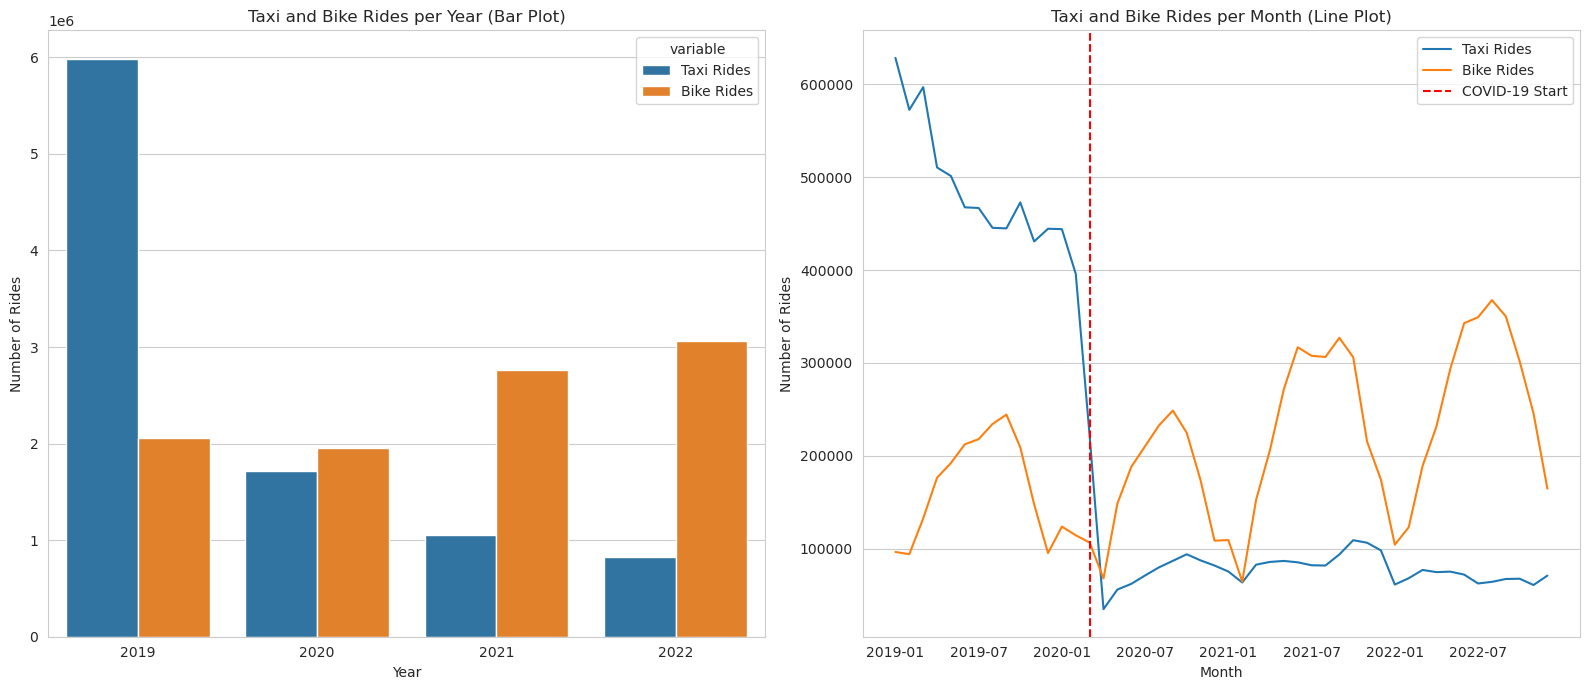

In [6]:
taxi_per_year = taxi.groupby(taxi['lpep_pickup_datetime'].dt.year).size()
bike_per_year = bike.groupby(bike['starttime'].dt.year).size()

bike_monthly_counts = bike["starttime"].dt.to_period('M').value_counts().sort_index()
taxi_monthly_counts = taxi["lpep_pickup_datetime"].dt.to_period('M').value_counts().sort_index()

data_year = pd.DataFrame({'Taxi Rides': taxi_per_year, 'Bike Rides': bike_per_year}).reset_index()

monthly_counts = pd.DataFrame({'Taxi Rides': taxi_monthly_counts, 'Bike Rides': bike_monthly_counts}).reset_index()

monthly_counts['index'] = monthly_counts['index'].astype(str)

fig, axes = plt.subplots(1, 2, figsize=(16, 7)) 

# Bar plot
sns.barplot(x='index', y='value', hue='variable', data=pd.melt(data_year, ['index']), ax=axes[0])
axes[0].set_title('Taxi and Bike Rides per Year (Bar Plot)')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Number of Rides')

# Line plot for ride per month per year
sns.lineplot(x='index', y='value', hue='variable', data=pd.melt(monthly_counts, ['index']), ax=axes[1])
axes[1].set_title('Taxi and Bike Rides per Month (Line Plot)')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Number of Rides')
axes[1].xaxis.grid(False)
axes[1].xaxis.set_major_locator(plt.MaxNLocator(10)) 

axes[1].axvline(x='2020-03', color='r', linestyle='--', label='COVID-19 Start')

plt.legend()

plt.tight_layout()

# Save the plot
plt.savefig(IMAGES_PATH + 'rides_per_year_month.png')

plt.show()

#### Number of rides before, during and after COVID pandemic

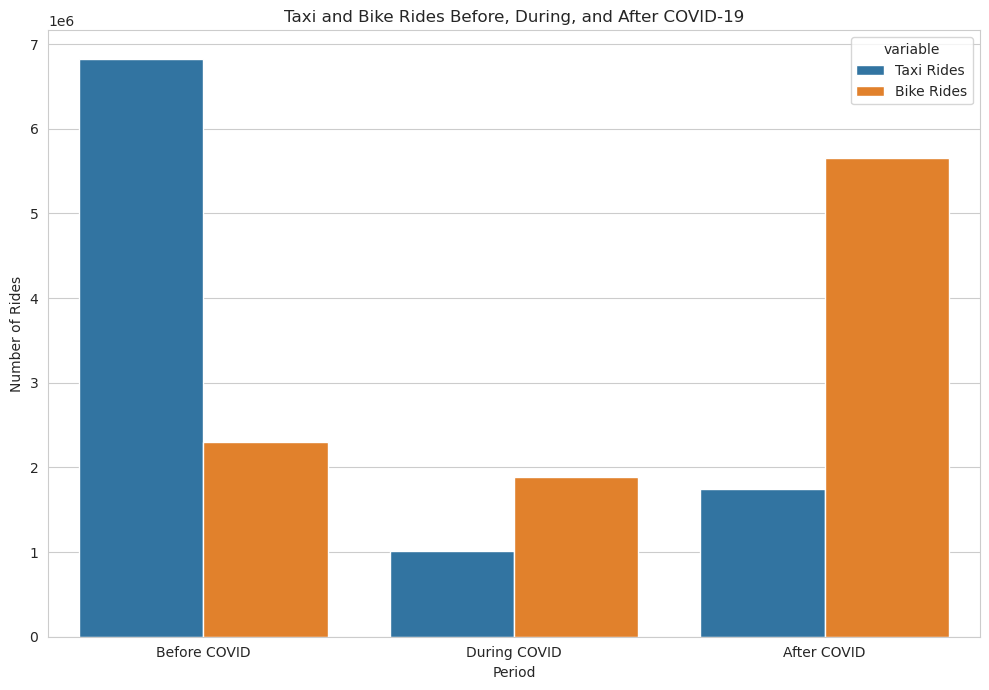

In [7]:
# bike/taxi before, during, after covid
before_covid_taxi = taxi[taxi['lpep_pickup_datetime'] < '2020-03-01']
during_covid_taxi = taxi[(taxi['lpep_pickup_datetime'] >= '2020-03-01') & (taxi['lpep_pickup_datetime'] < '2021-03-01')]
after_covid_taxi = taxi[taxi['lpep_pickup_datetime'] >= '2021-03-01']

before_covid_bike = bike[bike['starttime'] < '2020-03-01']
during_covid_bike = bike[(bike['starttime'] >= '2020-03-01') & (bike['starttime'] < '2021-03-01')]
after_covid_bike = bike[bike['starttime'] >= '2021-03-01']

before_covid_taxi_count = before_covid_taxi.shape[0]
during_covid_taxi_count = during_covid_taxi.shape[0]
after_covid_taxi_count = after_covid_taxi.shape[0]

before_covid_bike_count = before_covid_bike.shape[0]
during_covid_bike_count = during_covid_bike.shape[0]
after_covid_bike_count = after_covid_bike.shape[0]

covid_data = pd.DataFrame({
    'Period': ['Before COVID', 'During COVID', 'After COVID'],
    'Taxi Rides': [before_covid_taxi_count, during_covid_taxi_count, after_covid_taxi_count],
    'Bike Rides': [before_covid_bike_count, during_covid_bike_count, after_covid_bike_count]
})

# Plot
fig, axes = plt.subplots(1, 1, figsize=(10, 7))

sns.barplot(x='Period', y='value', hue='variable', data=pd.melt(covid_data, ['Period']), ax=axes)
axes.set_title('Taxi and Bike Rides Before, During, and After COVID-19')
axes.set_xlabel('Period')
axes.set_ylabel('Number of Rides')

plt.tight_layout()

# Save the plot
plt.savefig(IMAGES_PATH + 'rides_before_during_after_covid.png')

plt.show()

#### Period and Duration of rides

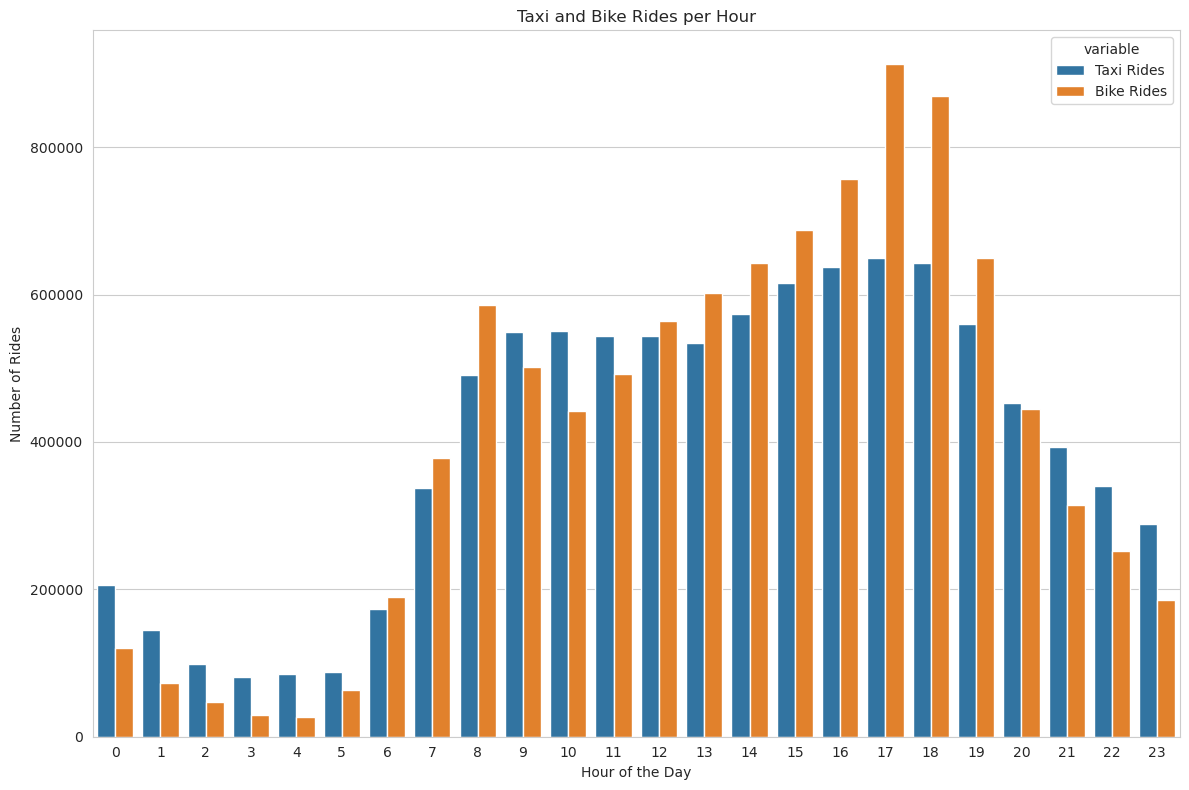

In [8]:
# Average rides per hour
taxi_per_hour = taxi.groupby(taxi['lpep_pickup_datetime'].dt.hour).size()
bike_per_hour = bike.groupby(bike['starttime'].dt.hour).size()

hourly_data = pd.DataFrame({
    'Hour': range(24),
    'Taxi Rides': taxi_per_hour,
    'Bike Rides': bike_per_hour
})

# Plot
fig, axes = plt.subplots(1, 1, figsize=(12, 8))

sns.barplot(x='Hour', y='value', hue='variable', data=pd.melt(hourly_data, ['Hour']), ax=axes)

axes.set_title('Taxi and Bike Rides per Hour')
axes.set_ylabel('Number of Rides')
axes.set_xlabel('Hour of the Day')

plt.tight_layout()

# Save the plot
plt.savefig(IMAGES_PATH + 'rides_per_hour.png')

plt.show()

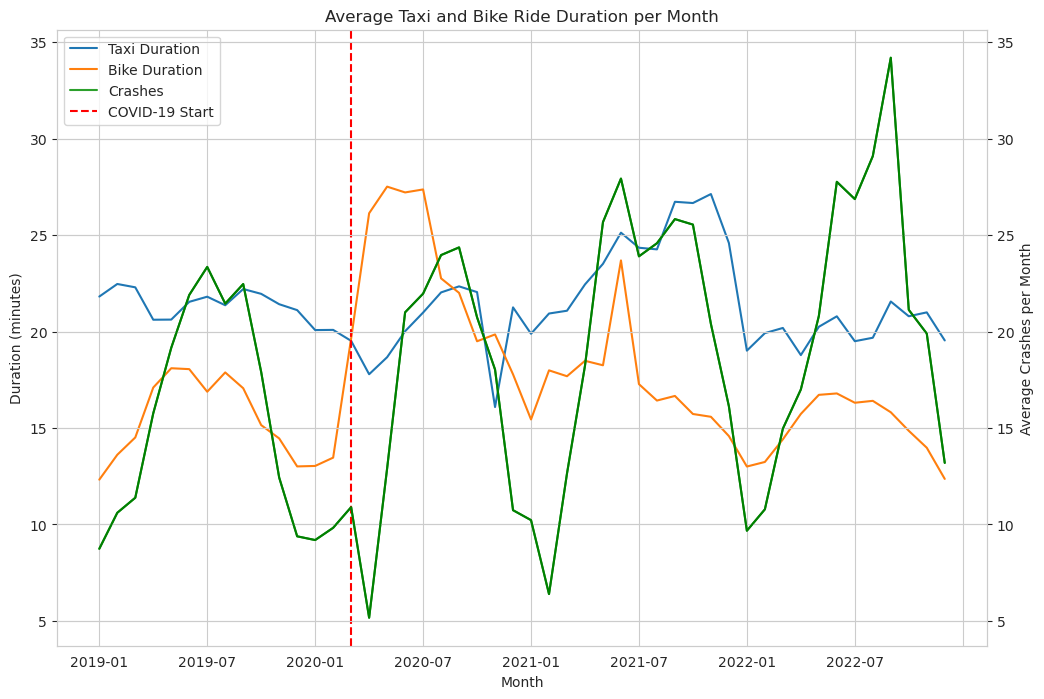

In [47]:
# Average ride duration per month
taxi['duration'] = (taxi['lpep_dropoff_datetime'] - taxi['lpep_pickup_datetime']).dt.total_seconds() / 60
bike['duration'] = (bike['stoptime'] - bike['starttime']).dt.total_seconds() / 60

taxi_duration_per_month = taxi.groupby(taxi['lpep_pickup_datetime'].dt.to_period('M'))['duration'].mean()
bike_duration_per_month = bike.groupby(bike['starttime'].dt.to_period('M'))['duration'].mean()

crash_count_per_day = crash.groupby([crash['CRASH DATE'].dt.to_period('M'), crash['CRASH DATE'].dt.day]).size()
average_crashes_per_month = crash_count_per_day.groupby(level=0).mean()

duration_data = pd.DataFrame({
    'Month': taxi_duration_per_month.index.strftime('%Y-%m'),
    'Taxi Duration': taxi_duration_per_month.values,
    'Bike Duration': bike_duration_per_month.values,
    'Crashes': average_crashes_per_month.values
})

# Plot
fig, ax1 = plt.subplots(1, 1, figsize=(12, 8))

sns.lineplot(x='Month', y='value', hue='variable', data=pd.melt(duration_data, ['Month']), ax=ax1)

ax1.set_title('Average Taxi and Bike Ride Duration per Month')
ax1.set_ylabel('Duration (minutes)')
ax1.set_xlabel('Month')

# Add secondary y-axis for crashes
ax2 = ax1.twinx()
sns.lineplot(x='Month', y='Crashes', data=duration_data, color='g', ax=ax2)
ax2.set_ylabel('Average Crashes per Month')

ax1.axvline(x='2020-03', color='r', linestyle='--', label='COVID-19 Start')
ax1.legend(loc='upper left')
ax1.xaxis.set_major_locator(plt.MaxNLocator(10))  # Set number of ticks to 12


# Save
plt.savefig(IMAGES_PATH + 'average_duration_per_month.png')

plt.show()

#### Distance of rides

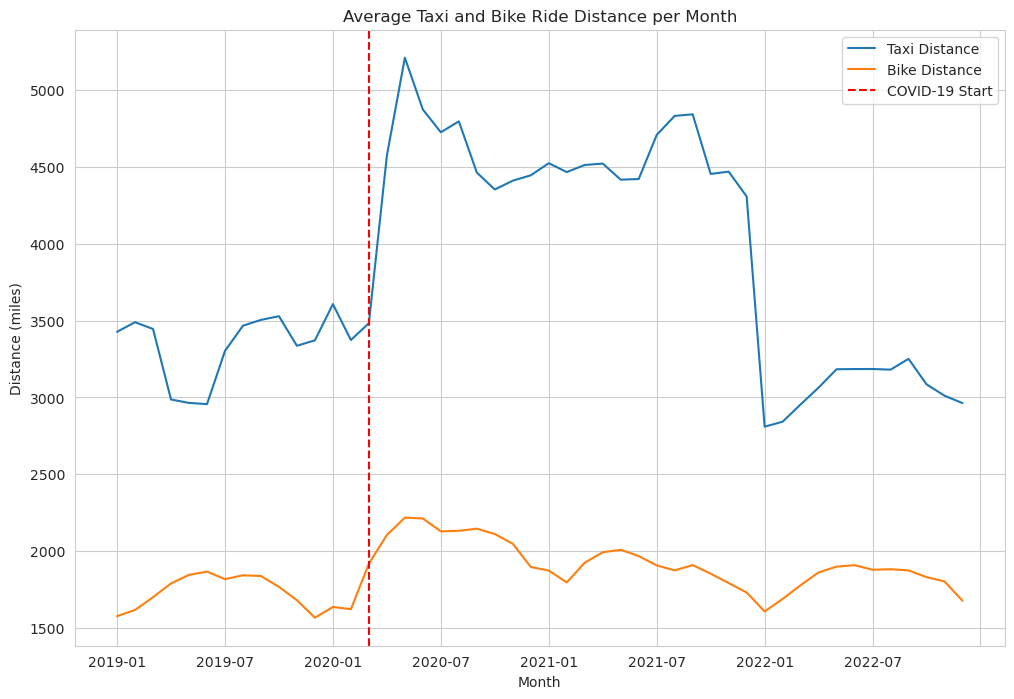

In [57]:
# Average distance per month
taxi_distance_per_month = taxi.groupby(taxi['lpep_pickup_datetime'].dt.to_period('M'))['trip_distance'].mean()
# Convert to meters
taxi_distance_per_month = taxi_distance_per_month * 1000
bike_distance_per_month = bike.groupby(bike['starttime'].dt.to_period('M'))['distance'].mean()

distance_data = pd.DataFrame({
    'Month': taxi_distance_per_month.index.strftime('%Y-%m'),
    'Taxi Distance': taxi_distance_per_month.values,
    'Bike Distance': bike_distance_per_month.values
})

# Plot
fig, axes = plt.subplots(1, 1, figsize=(12, 8))

sns.lineplot(x='Month', y='value', hue='variable', data=pd.melt(distance_data, ['Month']), ax=axes)

axes.set_title('Average Taxi and Bike Ride Distance per Month')
axes.set_ylabel('Distance (miles)')
axes.set_xlabel('Month')

axes.axvline(x='2020-03', color='r', linestyle='--', label='COVID-19 Start')
axes.xaxis.set_major_locator(plt.MaxNLocator(10)) 

plt.legend()

# Save
plt.savefig(IMAGES_PATH + 'average_distance_per_month.png')

plt.show()

#### Accidents per weekday and time of the day

/tmp/ipykernel_19301/2465188270.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  part_of_day = groupby_day.groupby(['day', 'partOfDay']).size().reset_index(name='Count')


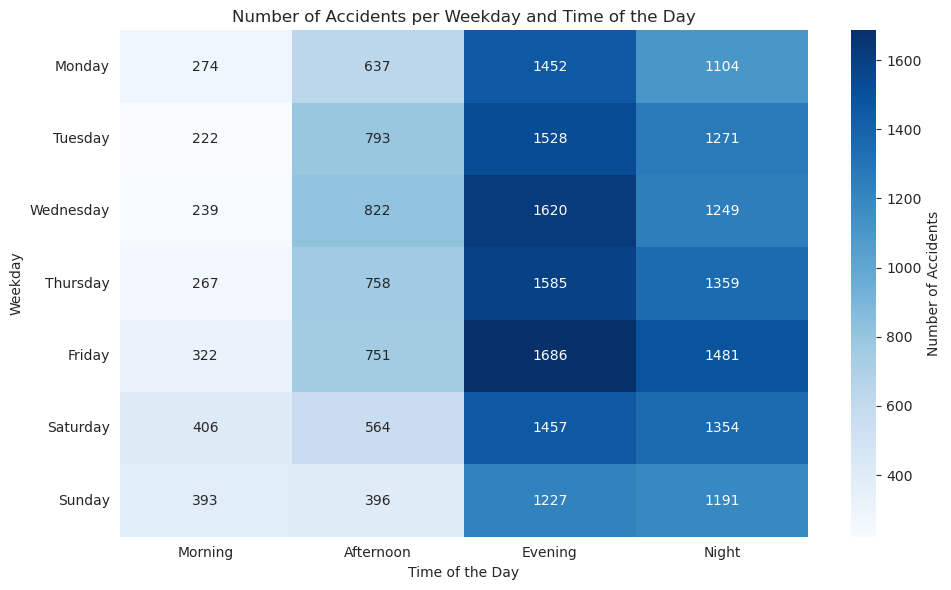

In [74]:
days_of_week = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
part_of_day_order = ['Morning', 'Afternoon', 'Evening', 'Night']

groupby_day = crash.copy()

groupby_day['day'] = groupby_day['CRASH DATE'].dt.day_name()
groupby_day['hour'] = groupby_day['CRASH TIME'].dt.hour
groupby_day['partOfDay'] = pd.cut(groupby_day['hour'], bins=[0, 6, 12, 18, 24], labels=part_of_day_order, right=False)

part_of_day = groupby_day.groupby(['day', 'partOfDay']).size().reset_index(name='Count')

part_of_day['day'] = pd.Categorical(part_of_day['day'], categories=days_of_week, ordered=True)
part_of_day['partOfDay'] = pd.Categorical(part_of_day['partOfDay'], categories=part_of_day_order, ordered=True)

pivot_df = part_of_day.pivot_table(index='day', columns='partOfDay', values='Count', fill_value=0)
pivot_df = pivot_df.reindex(part_of_day_order, axis=1)
pivot_df = pivot_df.astype(int)

# Plot
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_df, cmap='Blues', annot=True, fmt='d', cbar_kws={'label': 'Number of Accidents'})

plt.title('Number of Accidents per Weekday and Time of the Day')
plt.xlabel('Time of the Day')
plt.ylabel('Weekday')

plt.tight_layout()
plt.savefig(IMAGES_PATH + 'accidents_weekday_time_of_day.png', bbox_inches='tight')

plt.show()

#### Heatmaps with geographical data

The maps are not rendered on GitHub. Please see the .html maps files in the maps directory.

In [8]:
# Heatmap before covid bike
latitudes = before_covid_bike["start_lat"].values
longitudes = before_covid_bike["start_lng"].values

# Create a folium map centered at the mean latitude and longitude with tiles
center_latitude = np.mean(latitudes)
center_longitude = np.mean(longitudes)
mymap = folium.Map(location=[center_latitude, center_longitude], zoom_start=11, tiles='Esri.WorldImagery')

# Combine latitudes and longitudes into a list of point coordinates
points = list(zip(latitudes, longitudes))

# Create a HeatMap layer with the points and add it to the map
HeatMap(points).add_to(mymap)

# Save the map to an HTML file
mymap.save(MAPS_PATH + 'bike_heatmap_before_covid.html')

In [8]:
# Heatmap before covid taxi
data = taxi[['PULocationID']]
data = pd.merge(data, zones, left_on='PULocationID', right_on='OBJECTID')
data = data.sample(2000000)

# Create a folium map centered at a specific location with tiles
mymap = folium.Map(location=[40.785, -73.968], zoom_start=10, tiles="Esri.WorldImagery")

# Combine latitudes and longitudes into a list of point coordinates
points = list(zip(data['latitude'], data['longitude']))

# Create a HeatMap layer with the points and add it to the map
HeatMap(points).add_to(mymap)

# Save the map to an HTML file
mymap.save(MAPS_PATH + 'taxi_heatmap_before_covid.html')

In [14]:
# Accidents heatmap
data = crash.groupby(['LATITUDE', 'LONGITUDE']).size().reset_index(name='frequency')

mymap = folium.Map(location=[40.785, -73.968], zoom_start=10, tiles="Esri.WorldImagery")

# Combine latitudes and longitudes into a list of point coordinates
points = list(zip(data['LATITUDE'], data['LONGITUDE']))

# Create a HeatMap layer with the points and add it to the map
HeatMap(points, radius=10).add_to(mymap)

# Save the map to an HTML file
mymap.save(MAPS_PATH + 'crash_heatmap.html')

In [6]:
# Display all zones on a map
m = folium.Map(location=[40.7128, -74.0060], zoom_start=11)  # New York City coordinates

# Create a MarkerCluster layer to add markers for centroids
marker_cluster = MarkerCluster().add_to(m)

# Add markers for each centroid
for idx, row in zones.iterrows():
    # Create a popup containing the zone name
    popup = folium.Popup(row['zone'], parse_html=True)
    # Add marker to the MarkerCluster layer
    folium.Marker([row['centroid'].y, row['centroid'].x], popup=popup).add_to(marker_cluster)

# Save the map to an HTML file
m.save(MAPS_PATH + 'zones_map.html')